In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from astropy.constants import sigma_T
from statistics import mean
from sympy import symbols, solve

Optical depth : $\tau_T=n_e\sigma_TR$ \
Mean free path: $\bar l = \frac{R}{\tau_T}=\frac{1}{n_e\sigma_T}$

In [10]:
random.seed(0)

In [11]:
n_e = 10**3  # #/cm^3

# Case 1: $l= \bar l$

In [12]:
def mean_path_random_walk(Photons, opt_depth, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    R = mean_free_path*opt_depth
    l_mean = mean_free_path
    N = []
    for i in range(Photons):
        n = 1
        Inside_system = True
        x = 0
        y = 0
        while Inside_system:
            P = random.random()
            if P < np.exp(-opt_depth):
                N.append(n)
                Inside_system = False
            else:
                theta = 2*np.pi*random.random()
                x = x+l_mean*np.cos(theta)
                y = y+l_mean*np.sin(theta)
                if x**2+y**2 > R**2:
                    N.append(n)
                    Inside_system = False
                n = n+1
    return N

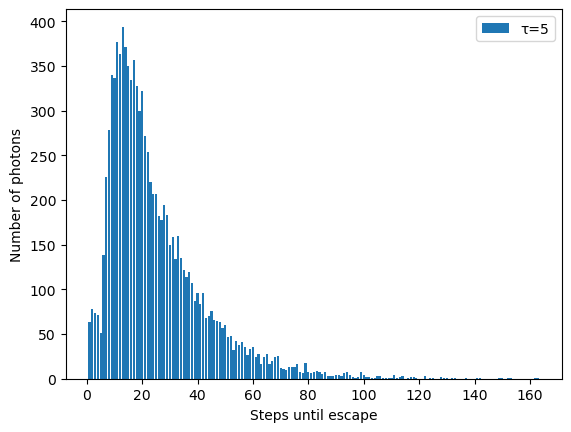

In [13]:
Approx1 = mean_path_random_walk(10000, 5, n_e)

labels, counts = np.unique(Approx1, return_counts=True)
plt.bar(labels, counts, align='center', label="τ=5")
# plt.gca().set_xticks(labels)
plt.xlabel('Steps until escape')
plt.ylabel('Number of photons')
plt.legend()
# plt.savefig("1st case,tau=10.png")
plt.show()

In [14]:
def Simple_step_tau_squared_corr(Photons, opt_depth, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    R = mean_free_path*opt_depth
    l_mean = mean_free_path
    N = []
    N_mean = []
    for tau in opt_depth:
        R = mean_free_path*tau
        for i in range(Photons):
            n = 1
            Not_escaped = True
            x = 0
            y = 0
            while Not_escaped:
                P = random.random()
                if P < np.exp(-tau):
                    N.append(n)
                    Not_escaped = False
                else:
                    theta = 2*np.pi*random.random()
                    x = x+l_mean*np.cos(theta)
                    y = y+l_mean*np.sin(theta)
                    if x**2+y**2 > R**2:
                        N.append(n)
                        Not_escaped = False
                    n = n+1
        N_mean.append(mean(N))
    return N_mean

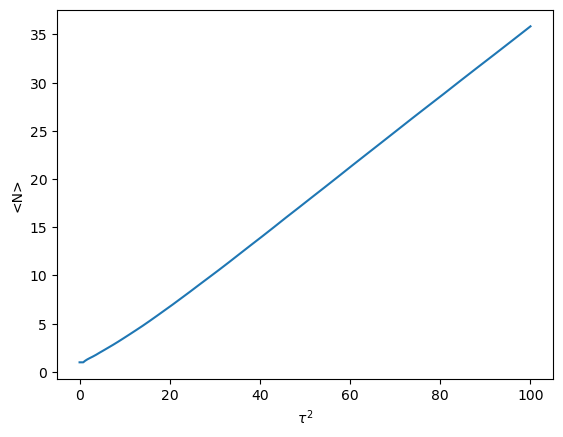

In [15]:
opt_depth = np.linspace(0.1, 10, 50)
N_mean = Simple_step_tau_squared_corr(10000, opt_depth, n_e)
plt.plot(opt_depth**2, N_mean)
plt.xlabel('$τ^2$')
plt.ylabel('<Ν>')
plt.title(f"")
# plt.savefig("1st case,Mean N vs tau.png")
plt.show()

# Case 2: $l= -\bar l lnξ$

In [16]:
def get_new_optical_depth(x_i, y_i, theta, R, n_e):
    if np.allclose(np.cos(theta), 0):
        x = x_i
        y = np.sin(theta)*(R**2-x**2)**(1/2)
    elif np.allclose(np.sin(theta), 0):
        y = y_i
        x = np.cos(theta)*(R**2-y**2)**(1/2)
    else:
#         alternative slow way
#         y_1 = symbols('y_1', real=True)
#         y_eq1 = (y_1-y_i+x_i*np.tan(theta))**2-(R**2-y_1**2)*np.tan(theta)**2
#         y_sol1 = np.array(solve(y_eq1, check=False), dtype=np.float64)

#         y = max(y_sol1) if theta < np.pi else min(y_sol1)
        
        y_1= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)+((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
        y_2= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)-((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
        y = max(y_1,y_2) if theta < np.pi else min(y_1,y_2)

        x = x_i+(y-y_i)/(np.tan(theta))
    D = ((x-x_i)**2+(y-y_i)**2)**(1/2)
    tau = (n_e*sigma_T.cgs.value*D)
    return tau

In [17]:
def Random_walk_variable_length(Photons, opt_depth, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    R = mean_free_path*opt_depth
    tau_center = opt_depth
    l_mean = mean_free_path
    N = []
    for i in range(Photons):
        n = 1
        Not_escaped = True
        x_i = 0
        y_i = 0
        theta = 2*np.pi*random.random()
        tau = np.inf  # So that P<np.exp(-tau) intitally always false.
        while Not_escaped:
            P = random.random()
            if (P < np.exp(-tau_center) and n == 1) or (P < np.exp(-tau)):
                N.append(n)
                Not_escaped = False
            else:
                l = -l_mean*np.log(1-random.random())
                x_i = x_i+l*np.cos(theta)
                y_i = y_i+l*np.sin(theta)
                if x_i**2+y_i**2 > R**2:
                    N.append(n)
                    Not_escaped = False
                theta = 2*np.pi*random.random()  # choose new direction
                if Not_escaped:
                    tau = get_new_optical_depth(x_i, y_i, theta, R, n_e)
                n = n+1
    return N

In [18]:
Approx2_2 = Random_walk_variable_length(1000, 2, n_e)
Approx2_5 = Random_walk_variable_length(1000, 5, n_e)
Approx2_10 = Random_walk_variable_length(1000, 10, n_e)

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:16: RuntimeWarning: invalid value encountered in double_scalars
  y_1= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)+((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y_2= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)-((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)


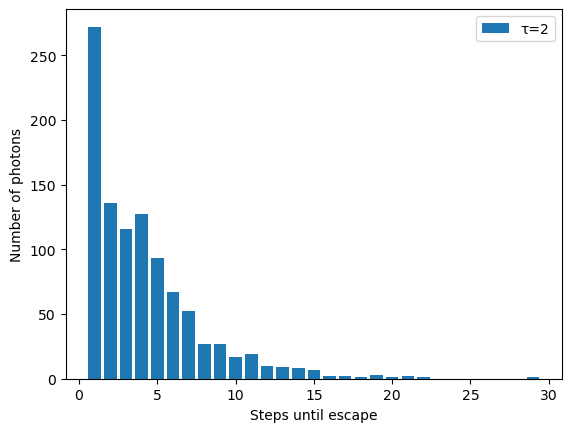

In [19]:
labels, counts = np.unique(Approx2_2, return_counts=True)
plt.bar(labels, counts, align='center', label="τ=2")
# plt.gca().set_xticks(labels)
plt.xlabel('Steps until escape')
plt.ylabel('Number of photons')
plt.legend()
# plt.savefig("2ndt case,tau=2.png")
plt.show()

In [20]:
def Step_tau_squared_corr(Photons, opt_depth, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    l_mean = mean_free_path
    N = []
    N_mean = []
    for tau_center in opt_depth:
        R = mean_free_path*tau_center
        for i in range(Photons):
            n = 1
            Not_escaped = True
            x_i = 0
            y_i = 0
            theta = 2*np.pi*random.random()
            tau = np.inf  # So that P<np.exp(-tau) intitally always false.
            while Not_escaped:
                P = random.random()
                if (P < np.exp(-tau_center) and n == 1) or (P < np.exp(-tau)):
                    N.append(n)
                    Not_escaped = False
                else:
                    l = -l_mean*np.log(1-random.random())
                    x_i = x_i+l*np.cos(theta)
                    y_i = y_i+l*np.sin(theta)
                    if x_i**2+y_i**2 > R**2:
                        N.append(n)
                        Not_escaped = False
                    theta = 2*np.pi*random.random()  # choose new direction
                    if Not_escaped:
                        tau = get_new_optical_depth(x_i, y_i, theta, R, n_e)
                    n = n+1
        N_mean.append(mean(N))
    return N_mean

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:16: RuntimeWarning: invalid value encountered in double_scalars
  y_1= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)+((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y_2= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)-((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)


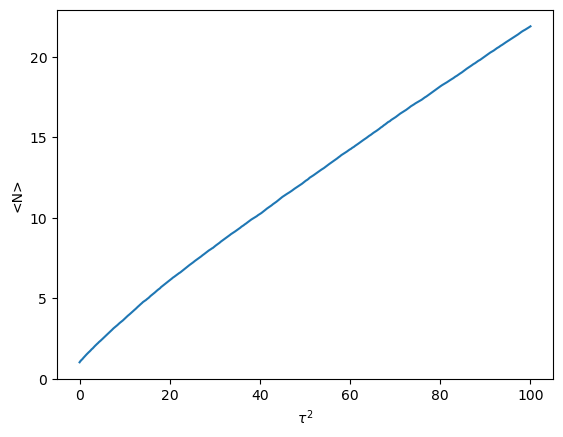

In [21]:
opt_depth = np.linspace(0.1, 10, 500)
Approx3 = Step_tau_squared_corr(100, opt_depth, n_e)
plt.plot(opt_depth**2, Approx3)
plt.xlabel('$τ^2$')
plt.ylabel('<Ν>')
plt.title(f"")
# plt.savefig("2nd case,Mean N vs tau 100ph.png")
plt.show()

# Absorption Included

In [22]:
def Random_walk_with_absorption(Photons, opt_depth, absorption, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    R = mean_free_path*opt_depth
    tau_center = opt_depth
    l_mean = mean_free_path
    N_free = []
    N_abs = []
    for i in range(Photons):
        n = 1
        Inside_system = True
        x_i = 0
        y_i = 0
        theta = 2*np.pi*random.random()
        tau = np.inf  # So that P<np.exp(-tau) intitally always false.
        while Inside_system:
            P = random.random()
            epsilon = random.random()
            if epsilon < absorption:
                N_abs.append(n)
                Inside_system = False
            elif (P < np.exp(-tau_center) and n == 1) or (P < np.exp(-tau)):
                N_free.append(n)
                Inside_system = False
            else:
                l = -l_mean*np.log(random.random())
                x_i = x_i+l*np.cos(theta)
                y_i = y_i+l*np.sin(theta)
                if x_i**2+y_i**2 > R**2:
                    N_free.append(n)
                    Inside_system = False
                theta = 2*np.pi*random.random()  # choose new direction
                if Inside_system:
                    tau = get_new_optical_depth(x_i, y_i, theta, R, n_e)
                n = n+1
    return N_free, N_abs

In [23]:
n_e = 10**3  # #/cm^3
N_free, N_abs = Random_walk_with_absorption(1000, 4, 0.4, n_e)

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:16: RuntimeWarning: invalid value encountered in double_scalars
  y_1= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)+((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y_2= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)-((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)


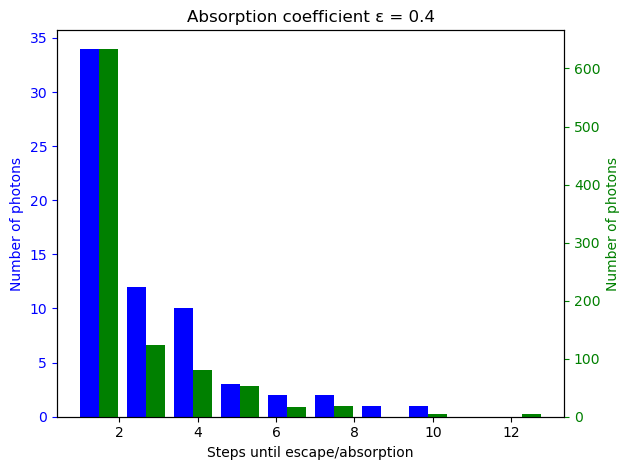

In [24]:
colors = ['b', 'g']

# sets up the axis and gets histogram data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([N_free, N_abs], color=colors)
n, bins, patches = ax1.hist([N_free, N_abs])
ax1.cla()  # clear the axis

# plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

# finishes the plot
ax1.set_ylabel("Number of photons", color=colors[0])
ax2.set_ylabel("Number of photons", color=colors[1])
ax1.set_xlabel("Steps until escape/absorption", color="k")
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.title(f"Absorption coefficient ε = 0.4")
plt.tight_layout()
# plt.savefig("Absorption e=0,01 with 1000 photons,ratio = 0,07.png")
plt.show()

In [25]:
len(N_free)/(len(N_abs)+len(N_free))

0.065

In [26]:
def Random_walk_with_absorption_tau_corr(Photons, opt_depth, absorption, n_e):
    mean_free_path = (n_e*sigma_T.cgs.value)**(-1)
    l_mean = mean_free_path
    N_free = []
    N_abs = []
    N_mean_free = []
    N_mean_abs = []
    for tau_center in opt_depth:
        R = mean_free_path*tau_center
        for i in range(Photons):
            n = 1
            Inside_system = True
            x_i = 0
            y_i = 0
            theta = 2*np.pi*random.random()
            tau = np.inf  # So that P<np.exp(-tau) intitally always false.
            while Inside_system:
                P = random.random()
                epsilon = random.random()
                if epsilon < absorption:
                    N_abs.append(n)
                    Inside_system = False
                elif (P < np.exp(-tau_center) and n == 1) or (P < np.exp(-tau)):
                    N_free.append(n)
                    Inside_system = False
                else:
                    l = -l_mean*np.log(random.random())
                    x_i = x_i+l*np.cos(theta)
                    y_i = y_i+l*np.sin(theta)
                    if x_i**2+y_i**2 > R**2:
                        N_free.append(n)
                        Inside_system = False
                    theta = 2*np.pi*random.random()  # choose new direction
                    if Inside_system:
                        tau = get_new_optical_depth(x_i, y_i, theta, R, n_e)
                    n = n+1
        N_mean_free.append(mean(N_free))
        N_mean_abs.append(mean(N_abs))
    return N_mean_free,N_mean_abs

In [27]:
opt_depth = np.linspace(0.1, 10, 500)
free01, abs_01 = Random_walk_with_absorption_tau_corr(100, opt_depth,0.1, n_e)

C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:16: RuntimeWarning: invalid value encountered in double_scalars
  y_1= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)+((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)
C:\Users\MargaritisX\AppData\Local\Temp\ipykernel_6196\2623849205.py:17: RuntimeWarning: invalid value encountered in double_scalars
  y_2= -(x_i*np.tan(theta)-y_i)/(1+np.tan(theta)**2)-((x_i*np.tan(theta)-y_i)**2-(1+np.tan(theta)**2)*(x_i*np.tan(theta)-y_i)**2)**(1/2)/(np.tan(theta)**2+1)


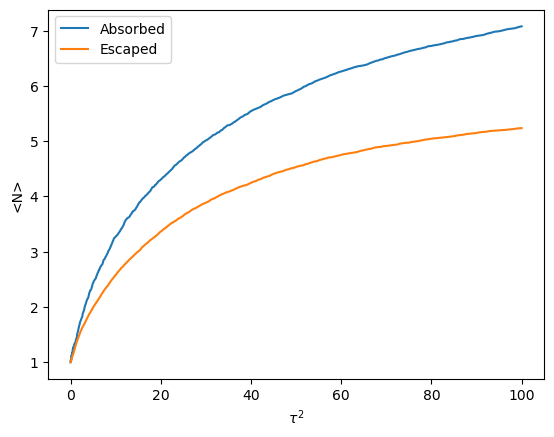

In [28]:
plt.plot(opt_depth**2, abs_01,label="Absorbed")
plt.plot(opt_depth**2, free01, label="Escaped")
# plt.plot(opt_depth**2, np.add(abs_01,free01).tolist())
plt.xlabel('$τ^2$')
plt.ylabel('<Ν>')
plt.legend()
plt.title(f"")
# plt.savefig("3rd case,Mean N vs tau 100ph.png")
plt.show()